In [1]:
### Script for sweeping gate voltage and measuring the pinch-off curves
### Uses Dynacool PPMS at MQML and Keithley sourcementers

# Import qcodes and other necessary packages
import qcodes as qc
import numpy as np
import time

# Import devices
from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from qcodes.instrument_drivers.QuantumDesign.DynaCoolPPMS import DynaCool

from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
from qcodes.instrument.base import Instrument

import matplotlib.pyplot as plt
import matplotlib
from time import sleep
import plottr
from plottr.client import DataSender
from plottr.qcodes_dataset import QcodesDatasetSubscriber
from qcodes.dataset.data_export import flatten_1D_data_for_plot


In [2]:
# Create station, instantiate instruments
Instrument.close_all()
station = qc.Station()
# Connect to ppms
#Instrument.find_instrument('ppms_cryostat')
ppms = DynaCool.DynaCool(name = "ppms_cryostat", address="TCPIP0::192.168.0.20::5000::SOCKET")
station.add_component(ppms)

# Connect to Keithley
keith = Keithley_2600(name="KL", address="TCPIP0::192.168.0.51::inst0::INSTR")
# Set voltages to 0
keith.smua.volt(0)
keith.smub.volt(0)

station.add_component(keith)
#for inst in station.components.values():
#    inst.print_readable_snapshot()

Connected to:  QuantumDesign dynacool (serial:N/A, firmware:N/A) in 0.07s
Connected to: Keithley Instruments Inc. 2614B (serial:4376445, firmware:3.2.2) in 0.02s


'KL'

In [3]:

#config.save_to_home

-3.8699298989746027
-3.8197914690071513
-4.218238210737614


<IPython.core.display.Javascript object>


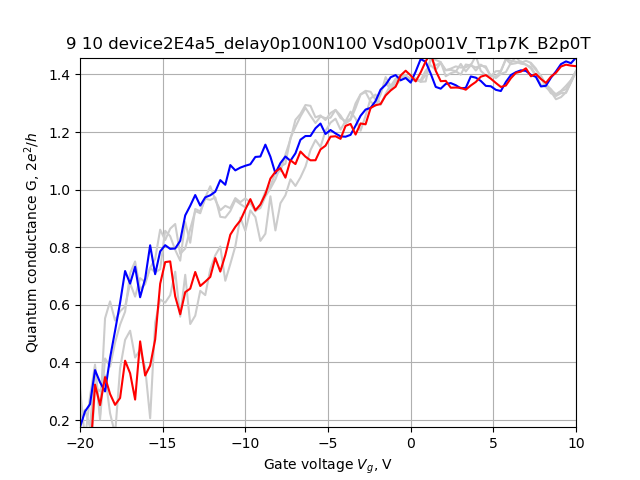

<IPython.core.display.Javascript object>


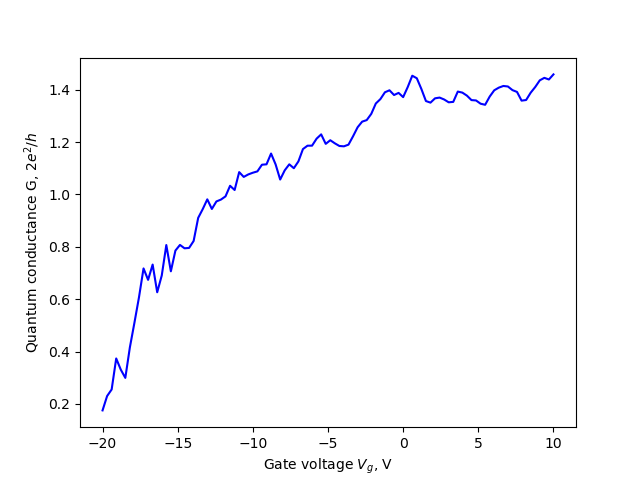

<IPython.core.display.Javascript object>


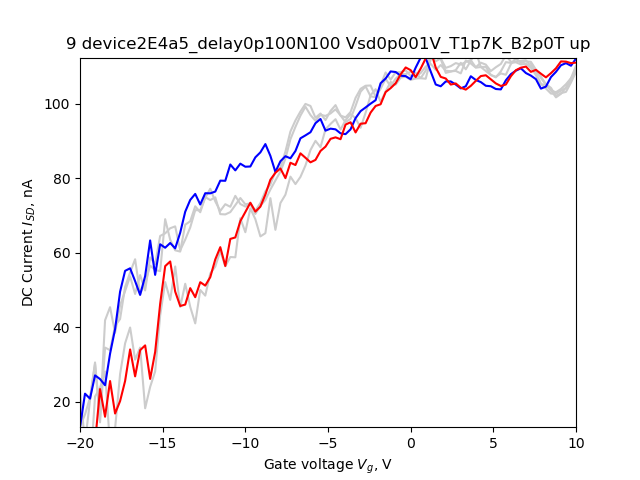

Text(0,0.5,'DC Current $I_{SD}$, mA')

In [8]:
# Initialize database, make new measurement
%matplotlib notebook

from qcodes.dataset.database import get_DB_location
from qcodes import config
import os.path
import os

mainpath = 'C:/Users/quantum_ppms/Desktop/Results/'
config.current_config.core.db_location = os.path.join(mainpath,'ajuan20181030.db')
#config.current_config.core.db_location = os.path.join(mainpath,'test_harry.db')
#config.current_config.core.db_location = os.path.join(mainpath,'QDev1ajuan5a10.db')

config.current_config

newpath = os.path.join(mainpath,'ajuan20181030') 
if not os.path.exists(newpath):
    os.makedirs(newpath)

figurepath = newpath

initialise_database()


#config.current_config.core.db_location = r'C:\Users\quantum_ppms\Desktop\Results\QDev795E_180927.db'
#config.current_config

initialise_database()

# dummy time varia

# devine new names for Keithley channels
bias=keith.smua.volt
gate=keith.smub.volt

current = keith.smua.curr
leakage = keith.smub.curr


def esoverh():
     DCV=bias() 
     DCcurrent=keith.smua.curr()
     cond=(DCcurrent/DCV)/7.7480917e-05 
     return cond
    
try:
    keith.smua.add_parameter("quantcond", label="G", unit="2e^2/h",
                               get_cmd=esoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del keith.smua.parameters['quantcond']

try:    
    keith.smub.add_parameter("quantcond", label="G", unit="2e^2/h",
                               get_cmd=esoverh)

except KeyError:
    print("parameter already exists. Deleting. Try again")
    del keith.smub.parameters['quantcond']
    
#print(current())
print(keith.smua.quantcond())
print(keith.smub.quantcond())
print(esoverh())

quant_cond = keith.smua.quantcond







#__________________FUNCTIONS FOR MEASURING_____________________________________
def wait_for_field():
    time.sleep(3)
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'holding':
        time.sleep(1)
        Magnet_state = ppms.magnet_state()
    return
def wait_for_field_ramp():
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'ramping':
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
    return
def field_ready():
    return ppms.magnet_state() == 'holding'
def wait_for_temp():
    Temp_state = ppms.temperature_state()
    while not (Temp_state is 'near' or  Temp_state is 'stable'):
        time.sleep(1)
        Temp_state = ppms.temperature_state()
    return


#__________________FIGURES INITIALIZATION______________________________________
fig, ax = plt.subplots(1)
ax.set_xlabel(r'Gate voltage $V_g$, V')
ax.set_ylabel(r'Quantum conductance G, $e^2/h$')
#plt.axis('off')
#columns = (' ')
#rows = ['temperatuure', 'field', 'bias']
#cell_text = [[1],[2],[3]]
#cell_text.reverse()
# Add a table at the bottom of the axes
#the_table = plt.table( cellText=cell_text, rowLabels=rows, rowColours=colors, colLabels=None, loc='bottom')
#Adjust layout to make room for the table:
#plt.subplots_adjust(left=0.2, bottom=0.2)
fig2, ax2 = plt.subplots(1)
plt.xlabel(r'Gate voltage $V_g$, V')
plt.ylabel(r'Quantum conductance G, $2e^2/h$')
fig3, ax3 = plt.subplots(1)
plt.xlabel(r'Gate voltage $V_g$, V')
plt.ylabel(r'DC Current $I_{SD}$, mA')



In [9]:
##### Clear figure
ax.cla()
ax3.cla()

In [10]:
gate_start = -20  #V
gate_end = 10      #V
Npoints = 100
timedelay = 0.1 #s
meas_range= np.linspace(gate_start, gate_end, Npoints)

# SD Vias Steps

In [6]:
bias_setpoint = 1 * 1e-3 #mV
temperature = 1.7 #K
magnetic_field = 0. * 1e-3 #mT


#SD Vias Sweep
initial = 1 *10**(-3) #mV
final = 25 *10**(-3) #mV
step = 65 *10**(-3) #mV

param_range = np.arange(initial, final, step)
for var_param in param_range:
    bias_setpoint = var_param
    Experiment_name = "Vsd"+"{:.3f}".format(bias_setpoint)+"V_"+"T"+"{:.1f}".format(temperature)+"K_B"+"{:.1f}".format(magnetic_field)+"T"
    list_name = list(Experiment_name)
    for i in range(len(Experiment_name)):
        if list_name[i] == ".":
            list_name[i] = "p"
    Experiment_name = ''.join(list_name)
    #print Experiment_name

    Sample_name = "QdevXXXX_XXXX_33_35"
    
    new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
    
    meas = Measurement()
    meas.register_parameter(gate)  # register the first independent parameter
    #meas.register_custom_parameter(name='gate_meas',label='gate_meas',unit='V',setpoints=(gate,))
    meas.register_parameter(quant_cond, setpoints=(gate,))  # now register the dependent one
    meas.register_parameter(current, setpoints=(gate,))  # now register the dependent one
    #meas.register_parameter(leakage, setpoints=(gate,))  # now register the dependent one
    meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
    meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
    meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
    meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
    #meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
    meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on
    meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value
    meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    #meas.add_before_run(lambda: ppms.field_setpoint(0.1), ())  # add a set-up action
    meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
    meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
    meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off
    #meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
    #meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize

    meas.write_period = 0.12
    
    for line in ax.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    for line in ax3.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    
    ax2.cla()
    #plt.xlabel(r'Gate voltage $V_g$, V')
    #plt.ylabel(r'Quantum conductance G, $e^2/h$')
    
    plt.figure(fig.number)    
    
    
    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)

        dataid_up = datasaver.run_id  # convenient to have for plotting 
        dataset = qc.load_by_id(dataid_up)
        labels = dataset.parameters.split(",")
        v_name = labels[0]
        c_name = labels[1]
        i_name = labels[2]

        plt.figure(fig.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'Quantum conductance G, $e^2/h$')
        pt11, = ax.plot(0,0,'b-',label='up')
        pt12, = ax.plot(0,0,'r-',label='down')
        plt.grid()

        plt.figure(fig3.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'DC Current $I_S$$_D$, nA')
        pt31, = ax3.plot(0,0,'b-',label='up')
        pt32, = ax3.plot(0,0,'r-',label='down')
        plt.grid()

        sample_name = dataset.sample_name
        exper_name = dataset.exp_name
        plt.title(str(dataid_up)+' '+sample_name+' '+exper_name)
        #plt.legend({'sweep down','sweep up'})
        # trace gate
        for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):

            gate(gate_setpoint)
            V_g = gate()
            I_sd = current()
            I_q = quant_cond()
            I_g = leakage()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_up)

            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) # 
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA

            plt.figure(fig.number)   
            if len(v)>1:
                pt11.set_xdata(v)
                pt11.set_ydata(c)
                ax.set_ylim([np.nanmin(c),np.nanmax(c)])
                ax.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig.canvas.draw()

            plt.figure(fig3.number)   
            if len(v)>1:
                pt31.set_xdata(v)
                pt31.set_ydata(i)
                ax3.set_ylim([np.nanmin(i),np.nanmax(i)])
                ax3.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig3.canvas.draw()

    plt.figure(fig2.number)
    plt.xlabel(r'Gate voltage $V_g$, V')
    plt.ylabel(r'Quantum conductance G, $e^2/h$')
    ax2.plot(v,c,'b-',label = 'up')  
    fig2.canvas.draw()

    plt.figure(fig.number)  
    new_experiment(name=Experiment_name+' down', sample_name=Sample_name)

    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)
        dataid_down = datasaver.run_id  # convenient to have for plotting 

        # Retrace gate
        for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
            gate(gate_setpoint+0.001)
            V_g = gate()
            I_sd = current()
            I_g = leakage()
            I_q = quant_cond()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_down)
            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) #
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA 

            plt.figure(fig.number) 
            pt12.set_xdata(v)
            pt12.set_ydata(c)
            fig.canvas.draw()

            plt.figure(fig3.number)   
            pt32.set_xdata(v)
            pt32.set_ydata(i)
            fig3.canvas.draw()



    plt.figure(fig2.number)         
    ax2.plot(v,c,'r-',label='down')   
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    #plt.legend({'up','down'})
    plt.grid()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.svg')



    plt.figure(fig.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.svg')

    plt.figure(fig3.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.svg')

ppms.field_setpoint(0)
wait_for_field()  



field ready
Starting experimental run with id: 2
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
field ready
Starting experimental run with id: 3
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!


VisaIOError: ('VI_ERROR_IO (-1073807298): Could not perform operation because of I/O error.', 'setting ppms_cryostat_field_setpoint to 0')

# Magnetic Field Steps

In [14]:
bias_setpoint = 1 * 1e-3 #mV
temperature = 1.7 #K
magnetic_field = 0. * 1e-3 #mT

gate_start = -20  #V
gate_end = 10      #V
Npoints = 100
timedelay = 0.1 #s
meas_range= np.linspace(gate_start, gate_end, Npoints)

#Magnetic Field Steps
initial = 0  * 1e-3 #mT
final = 8000 * 1e-3 #mT
step = 2000 * 1e-3 #mT

param_range = np.arange(initial, final, step)
for var_param in param_range:
    magnetic_field = var_param
    Experiment_name = "Vsd"+"{:.3f}".format(bias_setpoint)+"V_"+"T"+"{:.1f}".format(temperature)+"K_B"+"{:.1f}".format(magnetic_field)+"T"
    list_name = list(Experiment_name)
    for i in range(len(Experiment_name)):
        if list_name[i] == ".":
            list_name[i] = "p"
    Experiment_name = ''.join(list_name)
    #print Experiment_name

    Sample_name = "device2E4a5"+"_delay"+"{:.3f}".format(timedelay)+"N"+"{:.0f}".format(Npoints)
    list_namei = list(Sample_name)
    for i in range(len(Sample_name)):
        if list_namei[i] == ".":
            list_namei[i] = "p"
    Sample_name = ''.join(list_namei)
    new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
    
    meas = Measurement()
    meas.register_parameter(gate)  # register the first independent parameter
    #meas.register_custom_parameter(name='gate_meas',label='gate_meas',unit='V',setpoints=(gate,))
    meas.register_parameter(quant_cond, setpoints=(gate,))  # now register the dependent one
    meas.register_parameter(current, setpoints=(gate,))  # now register the dependent one
    #meas.register_parameter(leakage, setpoints=(gate,))  # now register the dependent one
    meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
    meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
    meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
    meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
    #meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
    meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on
    meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value
    meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    #meas.add_before_run(lambda: ppms.field_setpoint(0.1), ())  # add a set-up action
    meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
    meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
    meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off
    #meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
    #meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize

    meas.write_period = 0.12
    
    for line in ax.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    for line in ax3.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    
    ax2.cla()
    #plt.xlabel(r'Gate voltage $V_g$, V')
    #plt.ylabel(r'Quantum conductance G, $e^2/h$')
    
    plt.figure(fig.number)    
    
    
    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)

        dataid_up = datasaver.run_id  # convenient to have for plotting 
        dataset = qc.load_by_id(dataid_up)
        labels = dataset.parameters.split(",")
        v_name = labels[0]
        c_name = labels[1]
        i_name = labels[2]

        plt.figure(fig.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'Quantum conductance G, $2e^2/h$')
        pt11, = ax.plot(0,0,'b-',label='up')
        pt12, = ax.plot(0,0,'r-',label='down')
        plt.grid()

        plt.figure(fig3.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'DC Current $I_S$$_D$, nA')
        pt31, = ax3.plot(0,0,'b-',label='up')
        pt32, = ax3.plot(0,0,'r-',label='down')
        plt.grid()

        sample_name = dataset.sample_name
        exper_name = dataset.exp_name
        plt.title(str(dataid_up)+' '+sample_name+' '+exper_name)
        #plt.legend({'sweep down','sweep up'})
        # trace gate
        for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):

            gate(gate_setpoint)
            V_g = gate()
            I_sd = current()
            I_q = quant_cond()
            I_g = leakage()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_up)

            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) # 
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA

            plt.figure(fig.number)   
            if len(v)>1:
                pt11.set_xdata(v)
                pt11.set_ydata(c)
                ax.set_ylim([np.nanmin(c),np.nanmax(c)])
                ax.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig.canvas.draw()

            plt.figure(fig3.number)   
            if len(v)>1:
                pt31.set_xdata(v)
                pt31.set_ydata(i)
                ax3.set_ylim([np.nanmin(i),np.nanmax(i)])
                ax3.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig3.canvas.draw()

    plt.figure(fig2.number)
    plt.xlabel(r'Gate voltage $V_g$, V')
    plt.ylabel(r'Quantum conductance G, $2e^2/h$')
    ax2.plot(v,c,'b-',label = 'up')  
    fig2.canvas.draw()

    plt.figure(fig.number)  
    new_experiment(name=Experiment_name+' down', sample_name=Sample_name)

    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)
        dataid_down = datasaver.run_id  # convenient to have for plotting 

        # Retrace gate
        for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
            gate(gate_setpoint+0.001)
            V_g = gate()
            I_sd = current()
            I_g = leakage()
            I_q = quant_cond()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_down)
            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) #
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA 

            plt.figure(fig.number) 
            pt12.set_xdata(v)
            pt12.set_ydata(c)
            fig.canvas.draw()

            plt.figure(fig3.number)   
            pt32.set_xdata(v)
            pt32.set_ydata(i)
            fig3.canvas.draw()



    plt.figure(fig2.number)         
    ax2.plot(v,c,'r-',label='down')   
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    #plt.legend({'up','down'})
    plt.grid()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.svg')



    plt.figure(fig.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.svg')

    plt.figure(fig3.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.svg')

ppms.field_setpoint(0)
wait_for_field()  



Starting experimental run with id: 7
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Starting experimental run with id: 8
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during

KeyboardInterrupt: 

# Temperature Sweep

In [23]:
bias_setpoint = 10 * 1e-3 #mV
temperature = 1.7 #K
magnetic_field = 0. * 1e-3 #mT


#Temperature Sweep
initial = 1.8 #K
final = 3.0 #K
step = 1.0 #K

param_range = np.arange(initial, final, step)
for var_param in param_range:
    temperature = var_param
    Experiment_name = "Vsd"+"{:.3f}".format(bias_setpoint)+"V_"+"T"+"{:.1f}".format(temperature)+"K_B"+"{:.1f}".format(magnetic_field)+"T"
    list_name = list(Experiment_name)
    for i in range(len(Experiment_name)):
        if list_name[i] == ".":
            list_name[i] = "p"
    Experiment_name = ''.join(list_name)
    #print Experiment_name

    Sample_name = "Qdev795E_Ed2FE4_33_35"
    
    new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
    
    meas = Measurement()
    meas.register_parameter(gate)  # register the first independent parameter
    #meas.register_custom_parameter(name='gate_meas',label='gate_meas',unit='V',setpoints=(gate,))
    meas.register_parameter(quant_cond, setpoints=(gate,))  # now register the dependent one
    meas.register_parameter(current, setpoints=(gate,))  # now register the dependent one
    #meas.register_parameter(leakage, setpoints=(gate,))  # now register the dependent one
    meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
    meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
    meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
    meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
    #meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
    meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on
    meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value
    meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s
    #meas.add_before_run(lambda: ppms.field_setpoint(0.1), ())  # add a set-up action
    meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
    meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
    meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off
    #meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
    #meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize

    meas.write_period = 0.12
    
    for line in ax.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    for line in ax3.get_lines():
        line.set_color((0.8, 0.8, 0.8) )
    
    ax2.cla()
    #plt.xlabel(r'Gate voltage $V_g$, V')
    #plt.ylabel(r'Quantum conductance G, $e^2/h$')
    
    plt.figure(fig.number)    
    
    
    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)

        dataid_up = datasaver.run_id  # convenient to have for plotting 
        dataset = qc.load_by_id(dataid_up)
        labels = dataset.parameters.split(",")
        v_name = labels[0]
        c_name = labels[1]
        i_name = labels[2]

        plt.figure(fig.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'Quantum conductance G, $e^2/h$')
        pt11, = ax.plot(0,0,'b-',label='up')
        pt12, = ax.plot(0,0,'r-',label='down')
        plt.grid()

        plt.figure(fig3.number)
        plt.xlabel(r'Gate voltage $V_g$, V')
        plt.ylabel(r'DC Current $I_S$$_D$, nA')
        pt31, = ax3.plot(0,0,'b-',label='up')
        pt32, = ax3.plot(0,0,'r-',label='down')
        plt.grid()

        sample_name = dataset.sample_name
        exper_name = dataset.exp_name
        plt.title(str(dataid_up)+' '+sample_name+' '+exper_name)
        #plt.legend({'sweep down','sweep up'})
        # trace gate
        for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):

            gate(gate_setpoint)
            V_g = gate()
            I_sd = current()
            I_q = quant_cond()
            I_g = leakage()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_up)

            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) # 
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA

            plt.figure(fig.number)   
            if len(v)>1:
                pt11.set_xdata(v)
                pt11.set_ydata(c)
                ax.set_ylim([np.nanmin(c),np.nanmax(c)])
                ax.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig.canvas.draw()

            plt.figure(fig3.number)   
            if len(v)>1:
                pt31.set_xdata(v)
                pt31.set_ydata(i)
                ax3.set_ylim([np.nanmin(i),np.nanmax(i)])
                ax3.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig3.canvas.draw()

    plt.figure(fig2.number)
    plt.xlabel(r'Gate voltage $V_g$, V')
    plt.ylabel(r'Quantum conductance G, $e^2/h$')
    ax2.plot(v,c,'b-',label = 'up')  
    fig2.canvas.draw()

    plt.figure(fig.number)  
    new_experiment(name=Experiment_name+' down', sample_name=Sample_name)

    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)
        dataid_down = datasaver.run_id  # convenient to have for plotting 

        # Retrace gate
        for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
            gate(gate_setpoint+0.001)
            V_g = gate()
            I_sd = current()
            I_g = leakage()
            I_q = quant_cond()
            datasaver.add_result((gate, V_g), (quant_cond, I_q), (current, I_sd))
            time.sleep(timedelay)    #sleep

            dataset = qc.load_by_id(dataid_down)
            v = flatten_1D_data_for_plot(dataset.get_data(v_name)) #
            c = flatten_1D_data_for_plot(dataset.get_data(c_name)) #
            i = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA 

            plt.figure(fig.number) 
            pt12.set_xdata(v)
            pt12.set_ydata(c)
            fig.canvas.draw()

            plt.figure(fig3.number)   
            pt32.set_xdata(v)
            pt32.set_ydata(i)
            fig3.canvas.draw()



    plt.figure(fig2.number)         
    ax2.plot(v,c,'r-',label='down')   
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    #plt.legend({'up','down'})
    plt.grid()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_a.svg')



    plt.figure(fig.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'.svg')

    plt.figure(fig3.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name)
    plt.grid()
    fig.canvas.draw()
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.png', bbox_inches='tight')
    plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+sample_name+' '+Experiment_name+'_i.svg')

ppms.field_setpoint(0)
wait_for_field()  



field ready
Starting experimental run with id: 63
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
field ready
Starting experimental run with id: 64
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
field ready
Starting experimental run with id: 65
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
field ready
Starting experimental run with id: 66
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
field ready
